# <Center>Toxic Comment Classification </center>

For reading : https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

Contest link : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

## 1) Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
import scipy
import nltk
import re
import seaborn as sns

## 2) Reading input files

In [3]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [4]:
df_train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
len(df_train) , len(df_test)

(159571, 153164)

In [9]:
df_train.columns , df_test.columns

(Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
        'insult', 'identity_hate'],
       dtype='object'),
 Index(['id', 'comment_text'], dtype='object'))

In [10]:
# No of comments that are not described in any of the categories

# for train

no_of_comments = df_train[(df_train['toxic']!=1) & (df_train['severe_toxic']!=1) & (df_train['obscene']!=1) & (df_train['threat']!=1) & (df_train['insult']!=1) & (df_train['identity_hate']!=1)]
print(f'Percentage of such comments in train file : {(len(no_of_comments)/ len(df_train))*100}%')


Percentage of such comments in train file : 89.83211235124176%


In [11]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

## 3) Checking for relation between target features

For seaborn : https://pythonbasics.org/seaborn-heatmap/

<Axes: >

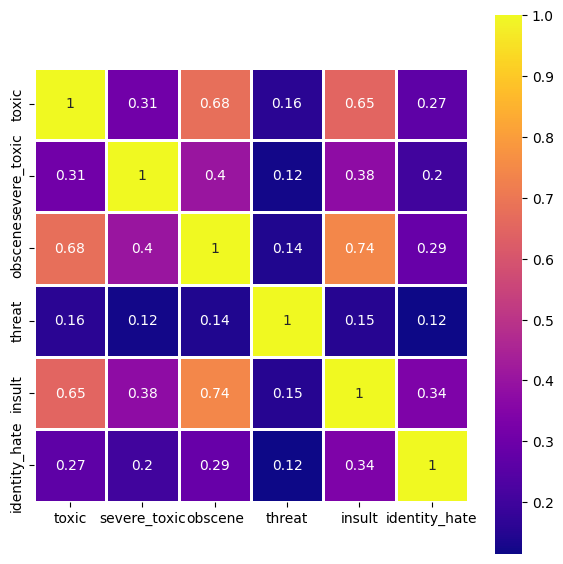

In [12]:
import seaborn as sns
color = plt.cm.plasma
plt.figure(figsize=(7,7))
sns.heatmap(df_train[cols].corr(),annot=True,cmap=color,linewidths=2,linecolor='white',square=True)

## 4) Comments cleaning




- First of all, make convert all text to its lowercase.
- In this part, it is necessary to check whether any row of comments has null values, if it has then fill it.
- If a comment contains words like i'm or what's, then change it to its full form.
- If a comment does not contain any null values but contains only whitespace/s then remove those white spaces with a single white space.
- It can happen that a comment/word may not have any letters, replace the comment/word with a single space.
- By mistake, if there are some leading and trailing whitespaces present, then remove them also.

#### For train file

In [13]:
# checking for null values
df_train['comment_text'].isnull().sum()

0

For short verb form that are commonly used : https://www.learnenglish.de/grammar/shortforms.html

For regular expression :
- https://www.w3schools.com/python/python_regex.asp
- https://note.nkmk.me/en/python-str-replace-translate-re-sub/




In [14]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r"can't","cannot",text)
  text = re.sub(r"shan't","shall not",text)
  text = re.sub(r"won't","will not",text)
  text = re.sub(r"n't"," not",text) # see the space before not.
  text = re.sub(r"i'm","i am",text)
  text = re.sub(r"what's","what is",text)
  text = re.sub(r"let's","let us",text)
  text = re.sub(r"'re"," are",text)
  text = re.sub(r"'s"," ",text)  # space because we dont know the tense , it can be is/has anything.
  text = re.sub(r"'ve"," have",text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub('\W', ' ', text)  # If the comment/word does not contain any alphabets
  text = re.sub('\s+', ' ', text) # If there are more than one whitespace simultenously, then replace them by only 1 whitespace
  text = text.strip(' ') # Removing leading and trailing white spaces
  return text


In [15]:
df_train['comment_text'] = df_train['comment_text'].apply(lambda text : clean_text(text))

In [16]:
df_train['comment_text'][:10]

,comment_text
0,explanation why the edits made under my userna...
1,d aww he matches this background colour i am s...
2,hey man i am really not trying to edit war it ...
3,more i cannot make any real suggestions on imp...
4,you sir are my hero any chance you remember wh...
5,congratulations from me as well use the tools ...
6,cocksucker before you piss around on my work
7,your vandalism to the matt shirvington article...
8,sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...


#### For test file

In [17]:
# checking for null values
df_test['comment_text'].isnull().sum()

0

In [18]:
df_test['comment_text'] = df_test['comment_text'].apply(lambda text : clean_text(text))

In [19]:
df_test['comment_text'][:10]

,comment_text
0,yo bitch ja rule is more succesful then you wi...
1,from rfc the title is fine as it is imo
2,sources zawe ashton on lapland
3,if you have a look back at the source the info...
4,i do not anonymously edit articles at all
5,thank you for understanding i think very highl...
6,please do not add nonsense to wikipedia such e...
7,dear god this site is horrible
8,only a fool can believe in such numbers the co...
9,double redirects when fixing double redirects ...


## 4) Converting into features and labels

In [20]:
X = df_train['comment_text']
X_test = df_test['comment_text']

In [21]:
len(X), len(X_test)

(159571, 153164)

For converting words to numbers : https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
tfd = TfidfVectorizer(stop_words='english',max_features=5000)
tfd

TfidfVectorizer(max_features=5000, stop_words='english')

In [24]:
# For train

X_data = tfd.fit_transform(X)
X_data

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3177057 stored elements in Compressed Sparse Row format>

In [25]:
# For test

X_test_data = tfd.transform(X_test)
X_test_data

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2617681 stored elements in Compressed Sparse Row format>

## 5) Building the model

Here, we will be building our model based on 2 approaches:

- 1) **Binary Relevance** - This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.

- 2) **Classifier Chains** - In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.

Using binary relevance

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_data, df_train[cols], test_size=0.2, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(C=12,max_iter=500)

lr.fit(x_train,y_train)

pred1 = lr.predict(x_train)
pred2 = lr.predict(x_test)

print('Training Accuracy is {}'.format(accuracy_score(y_train,pred1)))
print('Testing Accuracy is {}'.format(accuracy_score(y_test,pred2)))

ValueError: y should be a 1d array, got an array of shape (127656, 6) instead.

There was a issue of max iteration because model was not able to converge so max_iter was increased to 5000 and C=12.

https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati

In [ ]:
for label in cols:



  test_proba = lr.predict_proba(X_test_data)[:,1]
  submission_bin[label] = test_proba


In [ ]:
submission_bin.head()

In [ ]:
submission_bin.to_csv('submission_binary.csv',index=False)

This code has an accuracy of 96% on kaggle

Using classifier chains

In [ ]:
submission_chains = pd.read_csv('drive/My Drive/Pytorch_DataSet/Toxic Comment Classification/sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
for label in cols:

    y_train = df_train[label]
    lr.fit(X_data,y_train)
    y_pred_X = lr.predict(X_data)

    print('Training Accuracy is {}'.format(accuracy_score(y_train,y_pred_X)))

    test_y = lr.predict(X_test_data)
    test_y_prob = lr.predict_proba(X_test_data)[:,1]
    submission_chains[label] = test_y_prob

    # chain current label to X_dtm
    X_data = add_feature(X_data, y_train)
    print('Shape of X_data is now {}'.format(X_data.shape))

    # chain current label predictions to test_X_dtm
    X_test_data = add_feature(X_test_data, test_y)
    print('Shape of X_test_data is now {}'.format(X_test_data.shape))

In [ ]:
submission_chains.head()

In [ ]:
submission_chains.to_csv('submission_chains.csv',index=False)